In [5]:
import subprocess
import os
import math
from functions.basefunctions import *
from collections import defaultdict
import numpy as np
import time 

kbT_RNA = 0.6163207755

In [6]:
import pickle

with open('../data/fRNAhammingdistance.pkl', 'rb') as f:
    fRNAhammingdistance = pickle.load(f)

with open('../data/fRNAprob2.pkl', 'rb') as f:
    fRNAprob2 = pickle.load(f)

with open('../data/fRNAprob1.pkl', 'rb') as f:
    fRNAprob1 = pickle.load(f)

with open('../data/fRNAfolds.pkl', 'rb') as f:
    fRNAfolds = pickle.load(f)

In [7]:
len(fRNAhammingdistance), len(fRNAprob2)

(311016, 311016)

# Only left of the line from specific point, just to test
point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

These results are given in in data files 'site_scanning_probs_pval_seq_left'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


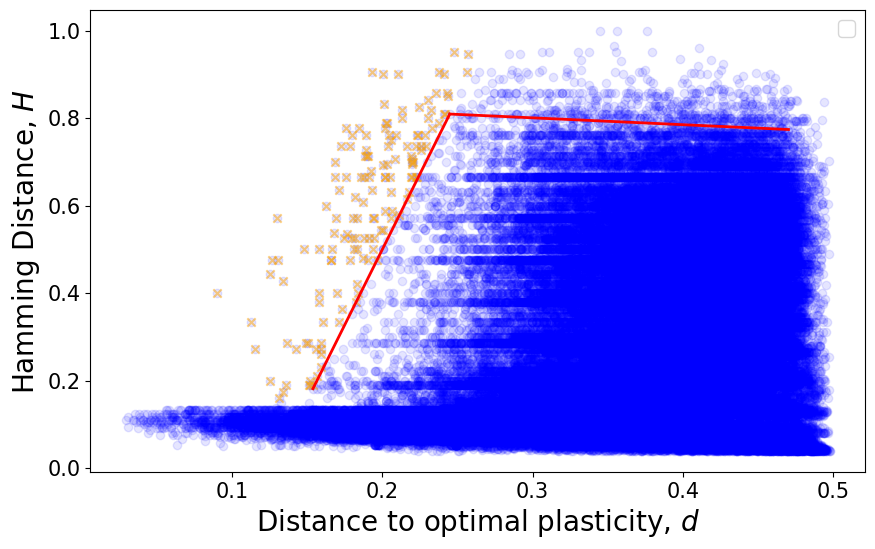

In [8]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [31]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left*_ssize100000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left = defaultdict(dict)


files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left(\d+)_ssize100000', file)
    
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left[(tuple(left_names[seq_number]),seq_number)][(fRNAhammingdistance[tuple(left_names[seq_number])],fRNAprob1[tuple(left_names[seq_number])],fRNAprob2[tuple(left_names[seq_number])])] = p_value_upper
    


68 ('FR442549||Fly small RNA', 'CGGAGGCGAATGCCAGACGC') 0.015760617870453797
20 ('FR329328|DQ689919|Piwi-interacting RNA (piRNA)', 'TGCAACAGCCTGAACAAAGGCAATTG') 0.008194209769770255
29 ('FR412251||Fly small RNA', 'AAGGAGCATCGTCCACCGGTG') 0.019506409763084487
72 ('FR443912||Fly small RNA', 'CGTGTCACCGGAGGCATGAAGGTGAA') 0.04598591664532048
1 ('FR017024||Putative conserved noncoding region (EvoFold)', 'GATGCCACCGCCTGGGTGGCCTC') 0.02231064216437051
77 ('FR447579||Fly small RNA', 'CTGCTGCGGATGGGGGCAGTAC') 0.026898799451784194
90 ('FR456139||Fly small RNA', 'GCAGAGCTGCAGCGATGCGGA') 0.01801179231016159
44 ('FR422481||Fly small RNA', 'AGTCAAACGGCAAAACGG') 0.031105406237797117
81 ('FR447806||Fly small RNA', 'CTGGAGCTGGAGCTGCAGCTA') 0.009943055800997191
16 ('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC') 0.010812287512418584
6 ('FR091786|DQ765545|Piwi-interacting RNA (piRNA)', 'TAGAAAGGACAAGGGTCCAATGATCCAGAC') 0.028536853903184167
89 ('FR454945||Fly small RNA', 'GATGGTC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


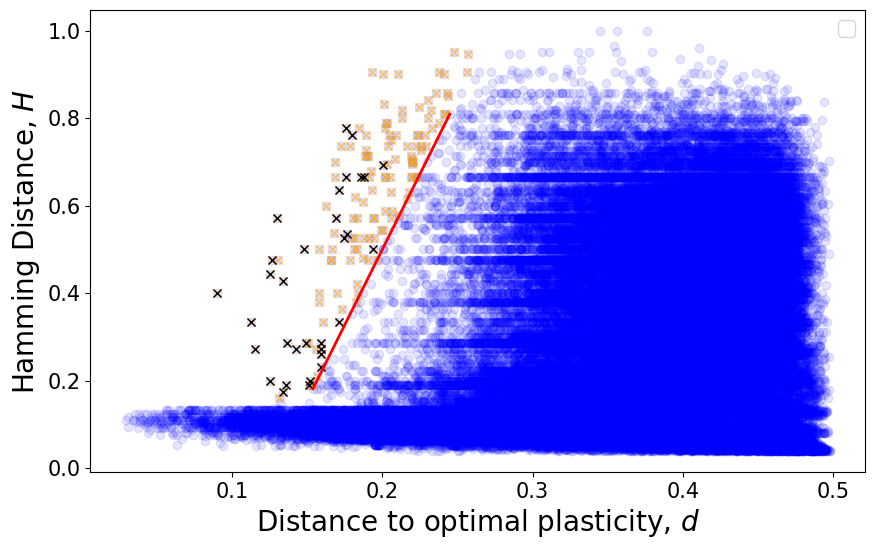

In [35]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name[0]], fRNAhammingdistance[name[0]], 'x', color='black')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [11]:
name = tuple(left_names[22])
print(name)

('FR336157||Putative conserved noncoding region (EvoFold)', 'GGTGAGAGGCACCACATTTACC')


In [12]:
nameandrankdist_hammingandprobs_pvals_left

defaultdict(dict,
            {(('FR442549||Fly small RNA', 'CGGAGGCGAATGCCAGACGC'),
              68): {(0.2,
               0.36627612189499636,
               0.33142034042369306): 0.015760617870453797},
             (('FR329328|DQ689919|Piwi-interacting RNA (piRNA)',
               'TGCAACAGCCTGAACAAAGGCAATTG'),
              20): {(0.23076923076923078,
               0.3409265231431471,
               0.3409265231431471): 0.008194209769770255},
             (('FR412251||Fly small RNA', 'AAGGAGCATCGTCCACCGGTG'),
              29): {(0.7619047619047619,
               0.32042381176631124,
               0.32042381176631124): 0.019506409763084487},
             (('FR443912||Fly small RNA', 'CGTGTCACCGGAGGCATGAAGGTGAA'),
              72): {(0.6923076923076923,
               0.3148187872948689,
               0.28485981864510124): 0.04598591664532048},
             (('FR017024||Putative conserved noncoding region (EvoFold)',
               'GATGCCACCGCCTGGGTGGCCTC'),
              1)

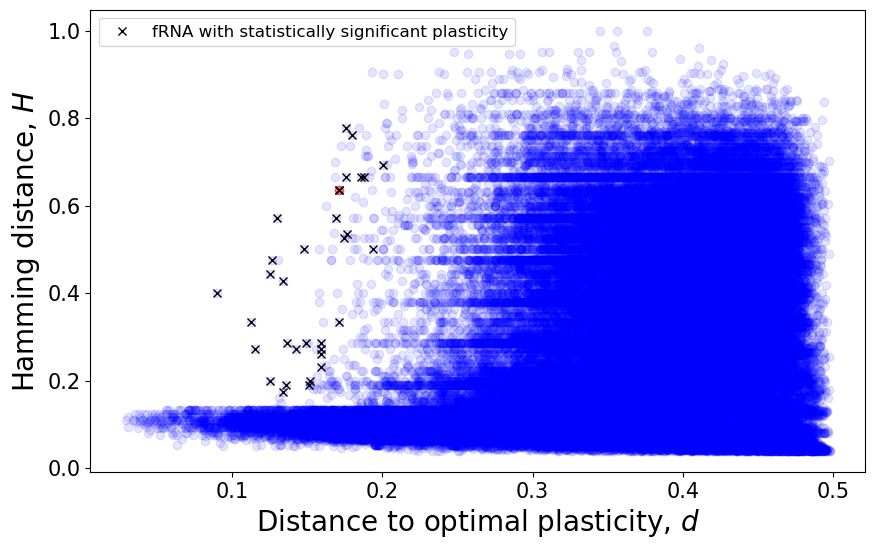

In [33]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
name = tuple(left_names[22])

observed_value_distance = diagonal_distances[name]
observed_value_hamming = fRNAhammingdistance[name]
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(observed_value_distance, observed_value_hamming, c='red', marker='o', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name[0]], fRNAhammingdistance[name[0]], 'x', color='black')
    if name[0] == tuple(left_names[22]):
        plt.plot(diagonal_distances[name[0]], fRNAhammingdistance[name[0]], 'x', color='black', label='fRNA with statistically significant plasticity')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
#plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=12)
# Show the plot
plt.show()

In [29]:
len(selected_names)

237461

('FR336157||Putative conserved noncoding region (EvoFold)', 'GGTGAGAGGCACCACATTTACC')
[0.01582323657237672]


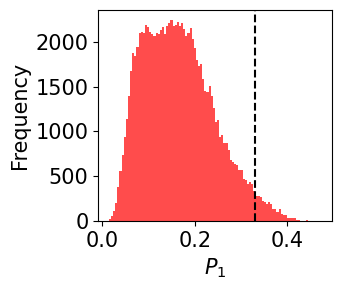

In [24]:
#example for seq 0
with open('../data/site_scanning_probs_pval_seq_left22_ssize100000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq_left22_ssize100000 = pickle.load(f)
probs2 = site_scanning_probs_pval_seq_left22_ssize100000['probs2']

# Plot the distributions
name = tuple(left_names[22])
print(name)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=100, alpha=0.7, color='red')
plt.xlabel(r'$P_1$',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Site-Scanning Distribution',fontsize=12)

observed_value = fRNAprob2[name]
pval = list(nameandrankdist_hammingandprobs_pvals_left[(name,22)].values())
print(pval)
plt.axvline(x=observed_value, color='black', linestyle='--',label= r'p-value='+str(np.round(pval[0],2)))
#plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

('FR336157||Putative conserved noncoding region (EvoFold)', 'GGTGAGAGGCACCACATTTACC')
0.32880174073784496
0.02047407482472763


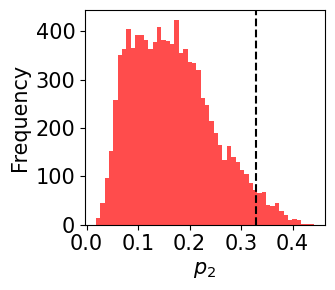

In [30]:
#example for seq 0
import pickle
with open('../data/site_scanning_probs_pval_seq_left22_ssize10000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq_left22_ssize10000 = pickle.load(f)
probs2 = site_scanning_probs_pval_seq_left22_ssize10000['probs2']

# Plot the distributions
name = tuple(left_names[22])
print(name)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='red')
plt.xlabel(r'$p_2$',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Site-Scanning Distribution',fontsize=12)

seq_number = 22
# Read the file into a DataFrame
with open('../data/site_scanning_probs_pval_seq_left22_ssize10000.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract probs2 and append to the list
probs2 = list(data['probs2'])
observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value

mean = np.mean(probs2)
std_dev = np.std(probs2)

# Compute the z-score for the observed value
z_score = (observed_value - mean) / std_dev

# One-tailed p-value (upper-tail)
pval = 1 - norm.cdf(z_score)

observed_value = fRNAprob2[name]
print(observed_value)
print(pval)
plt.axvline(x=observed_value, color='black', linestyle='--',label= r'p-value='+str(np.round(pval,2)))
#plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Now get a wider range of points
 can we optimise such that all points are tested?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


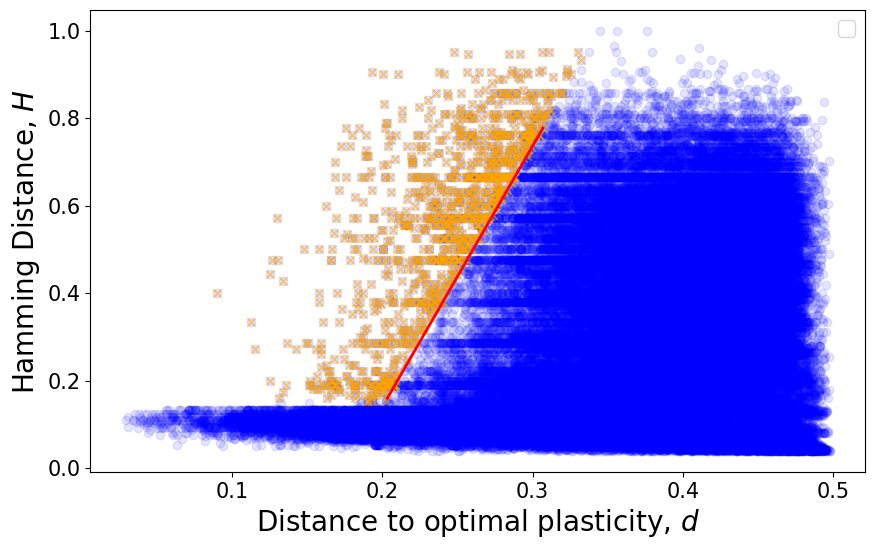

In [36]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.20333026388667144,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line

left_names = selected_names[left_mask]



left_names_tot = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()



In [38]:
names_to_check = []
for name in left_names_tot:
    if left_names_tot in left_names:
        names_to_check.append(name)

In [40]:
with open(f"../data/selected_names_left_minus_a.pkl","rb") as f:
        left_names_minus = pickle.load(f)

In [43]:
tuple(left_names_minus[22])

('FR036482||Putative conserved noncoding region (EvoFold)',
 'GCTTCATGTGCATGAATC')

# fRNA significant length

In [17]:
siglengthRNA = []
sighammingRNA = []
sigdistRNA = []
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    siglengthRNA.append(len(name[0][1]))
    sighammingRNA.append(fRNAhammingdistance[name[0]])
    sigdistRNA.append(diagonal_distances[name[0]])

In [18]:
lengthRNA = []
for name in selected_names:
    lengthRNA.append(len(name[1]))


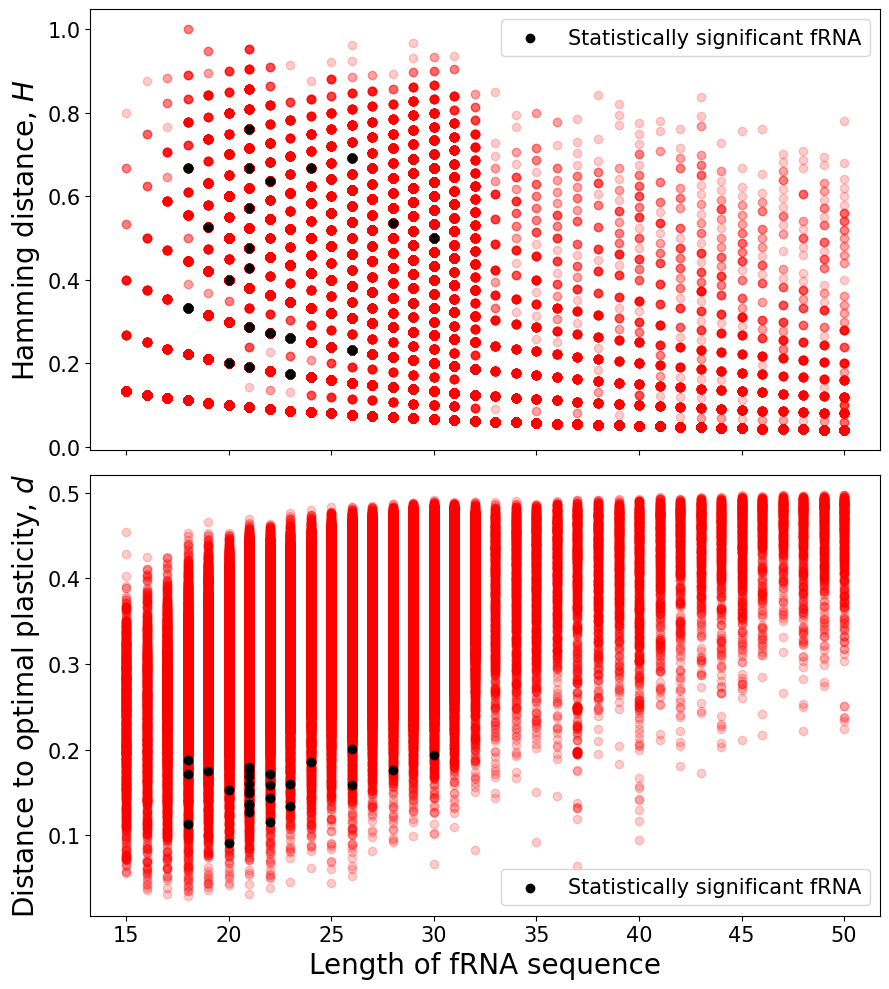

In [19]:
import matplotlib.pyplot as plt

# Sample data for demonstration

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10),sharex=True)

# First subplot
ax1.scatter(lengthRNA, selected_hamming_values, c='red', marker='o', alpha=0.2 )
ax1.scatter(siglengthRNA, sighammingRNA, c='black', marker='o', alpha=1.0, label='Statistically significant fRNA')
#ax1.set_xlabel('Length of fRNA sequence', fontsize=20)
ax1.set_ylabel('Hamming distance, $H$', fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.legend(fontsize=15)

# Second subplot
ax2.scatter(lengthRNA, selected_min_distances, c='red', marker='o', alpha=0.2)
ax2.scatter(siglengthRNA, sigdistRNA, c='black', marker='o', alpha=1.0, label='Statistically significant fRNA')
ax2.set_xlabel('Length of fRNA sequence', fontsize=20)
ax2.set_ylabel('Distance to optimal plasticity, $d$', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.legend(fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
import scipy.stats as stats
pearsonr, _ = stats.pearsonr(lengthRNA, selected_hamming_values)
print('Pearson correlation between length and Hamming distance:', pearsonr)
pearsonr, _ = stats.pearsonr(lengthRNA, selected_min_distances)
print('Pearson correlation between length and distance to optimal plasticity:', pearsonr)

Pearson correlation between length and Hamming distance: -0.04858809151516878
Pearson correlation between length and distance to optimal plasticity: 0.5097966284637734
